In [ ]:
!pip install datasets --quiet
!pip install presidio-analyzer --quiet
!pip install presidio_anonymizer --quiet
!pip install presidio-anonymizer --quiet

In [ ]:
from datasets import load_dataset #Dataset, IterableDataset
import pprint
import json
import spacy
from google.colab import drive
drive.mount('/content/drive')
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from spacy import displacy
from tqdm import tqdm
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from presidio_analyzer import AnalyzerEngine
from presidio_anonymizer import AnonymizerEngine, RecognizerResult
from datasets import load_dataset, load_from_disk, Dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/266 - Natural Language Processing/Final Project/'

In [ ]:
# full, test dataset select data slicing of original json
# global variables
model_name = 'presidio-en_core_web_lg' # update to select the right path
task = 'mask'
size = 'mini'
split = 'test'

In [ ]:
!python -m spacy download en_core_web_lg --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# general functions
def select_data(split, task, size):
    """
    Loads the appropriate dataset per folder structure here: https://drive.google.com/drive/folders/1C3h3rXdbr9nVAC3_G_I-72DfKNiDU_Pa
    Input:
        Split: ['train', 'val', 'test']
        Task: ['ner', 'mask', 'both']
        Size: ['testing', 'mini', 'full']
    Returns:
        Huggingface dataset
    """
    if split not in ['train', 'val', 'test']:
        raise ValueError("Split value must be in ['train', 'val', 'test']")
    if task not in ['ner', 'mask', 'both']:
        raise ValueError("Task value must be in ['ner', 'mask', 'both']")
    if size not in ['testing', 'mini', 'full']:
        raise ValueError("Size value must be in ['testing', 'mini', 'full']")

    path_label = {'both': 'longformer', 'ner': 'longformer_ner', 'mask': 'longformer_mask'}
    # path_label = {'both': 'longformer', 'ner': 'longformer_ner', 'mask': 'longformer_4096'}

    if size == 'testing':
        ds = load_from_disk(f'{path}/data/tab/{path_label[task]}/lf_{split}_testing')
    if size == 'mini':
        if split == 'train':
            ds = load_from_disk(f'{path}/data/tab/{path_label[task]}/lf_{split}_400')
        else:
            ds = load_from_disk(f'{path}/data/tab/{path_label[task]}/lf_{split}_50')
    if size == 'full':
        ds = load_from_disk(f'{path}/data/tab/{path_label[task]}/lf_{split}')

    return ds

In [ ]:
ds = select_data(split, task, size)
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'ner_tags', 'mask_tags', 'text_spans', 'tokens', 'text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 98
    })
})

ner_type = ['O', 'B-PERSON', 'I-PERSON', 'B-CODE', 'I-CODE', 'B-LOC', 'I-LOC', 'B-ORG', 'I-ORG',
            'B-DEM', 'I-DEM', 'B-DATETIME', 'I-DATETIME', 'B-QUANTITY', 'I-QUANTITY', 'B-MISC', 'I-MISC']
masking_type = ['NO_MASK', 'DIRECT', 'QUASI']

# Sample Presidio Output

In [ ]:


# Set up the engine, loads the NLP module (spaCy model by default) and other PII recognizers
analyzer = AnalyzerEngine()

# Call analyzer to get results
results = analyzer.analyze(text=ds['train'][0]['text'],
                           #entities=["PHONE_NUMBER"],
                           language='en')
print(results)

[type: LOCATION, start: 72, end: 94, score: 0.85, type: NRP, start: 295, end: 302, score: 0.85, type: PERSON, start: 317, end: 329, score: 0.85, type: PERSON, start: 334, end: 350, score: 0.85, type: PERSON, start: 355, end: 369, score: 0.85, type: PERSON, start: 377, end: 388, score: 0.85, type: DATE_TIME, start: 412, end: 428, score: 0.85, type: PERSON, start: 469, end: 477, score: 0.85, type: LOCATION, start: 502, end: 508, score: 0.85, type: DATE_TIME, start: 711, end: 715, score: 0.85, type: DATE_TIME, start: 734, end: 738, score: 0.85, type: DATE_TIME, start: 859, end: 874, score: 0.85, type: DATE_TIME, start: 1215, end: 1230, score: 0.85, type: DATE_TIME, start: 1388, end: 1399, score: 0.85, type: DATE_TIME, start: 1551, end: 1565, score: 0.85, type: PERSON, start: 1823, end: 1851, score: 0.85, type: DATE_TIME, start: 2033, end: 2054, score: 0.85, type: DATE_TIME, start: 2103, end: 2120, score: 0.85, type: DATE_TIME, start: 2227, end: 2232, score: 0.85, type: DATE_TIME, start: 2

In [ ]:
results

[type: LOCATION, start: 72, end: 94, score: 0.85,
 type: NRP, start: 295, end: 302, score: 0.85,
 type: PERSON, start: 317, end: 329, score: 0.85,
 type: PERSON, start: 334, end: 350, score: 0.85,
 type: PERSON, start: 355, end: 369, score: 0.85,
 type: PERSON, start: 377, end: 388, score: 0.85,
 type: DATE_TIME, start: 412, end: 428, score: 0.85,
 type: PERSON, start: 469, end: 477, score: 0.85,
 type: LOCATION, start: 502, end: 508, score: 0.85,
 type: DATE_TIME, start: 711, end: 715, score: 0.85,
 type: DATE_TIME, start: 734, end: 738, score: 0.85,
 type: DATE_TIME, start: 859, end: 874, score: 0.85,
 type: DATE_TIME, start: 1215, end: 1230, score: 0.85,
 type: DATE_TIME, start: 1388, end: 1399, score: 0.85,
 type: DATE_TIME, start: 1551, end: 1565, score: 0.85,
 type: PERSON, start: 1823, end: 1851, score: 0.85,
 type: DATE_TIME, start: 2033, end: 2054, score: 0.85,
 type: DATE_TIME, start: 2103, end: 2120, score: 0.85,
 type: DATE_TIME, start: 2227, end: 2232, score: 0.85,
 type: 

# Evaluation

Assuming that DIRECT or QUASI mask types are both masked per the publication

In [ ]:
def predict_mask_labels(dataset):
    """
    Uses Presidio's AnalyzerEngine to predict binary MASK labels for tokens in each text,
    calculating end positions based on token start positions.
    """
    predictions = []
    ground_truths = []

    for example in tqdm(dataset):
        text = example['text']
        mask_tags = example['mask_tags']  # Ground truth mask tags (1 or 2 for MASK, 0 for NO MASK)

        # Convert mask_tags to binary (1 for MASK, 0 for NO MASK)
        binary_ground_truths = [1 if tag in [1, 2] else 0 for tag in mask_tags]

        # Run Presidio's analyzer to detect PII entities in the text
        results = analyzer.analyze(text=text, entities=[], language="en")

        # Initialize all tokens as NO MASK (0), and set entities to MASK (1)
        predicted_mask_tags = [0] * len(example['tokens'])
        num_tokens = len(example['tokens'])

        for result in results:
            # Each result contains the start and end character indices of detected PII
            entity_start = result.start
            entity_end = result.end

            # Loop through tokens and assign MASK based on entity spans
            for i, token_start in enumerate(example['text_spans']):
                # Calculate end position of the token
                if i < num_tokens - 1:
                    token_end = example['text_spans'][i + 1]
                else:
                    token_end = len(text)  # Last token to end of text

                # Check if the token is within the entity span
                if token_start >= entity_start and token_start < entity_end:
                    predicted_mask_tags[i] = 1  # Set as MASK

        predictions.extend(predicted_mask_tags)
        ground_truths.extend(binary_ground_truths)

    return predictions, ground_truths

In [ ]:
# Run prediction and gather results
predictions, ground_truths = predict_mask_labels(ds['train'])

# Evaluate using classification report
print(classification_report(ground_truths, predictions, target_names=["NO MASK", "MASK"]))

100%|██████████| 98/98 [01:00<00:00,  1.63it/s]


              precision    recall  f1-score   support

     NO MASK       0.96      0.88      0.92    131594
        MASK       0.13      0.32      0.18      7154

    accuracy                           0.85    138748
   macro avg       0.54      0.60      0.55    138748
weighted avg       0.92      0.85      0.88    138748



<function matplotlib.pyplot.show(close=None, block=None)>

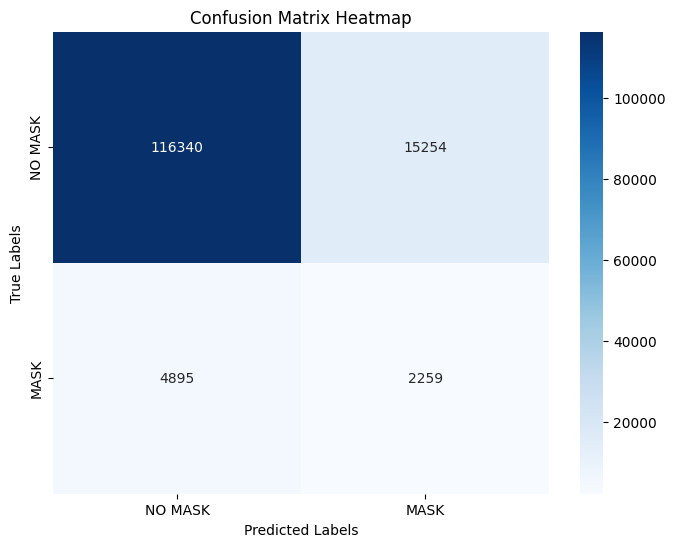

In [ ]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(ground_truths, predictions)

# Plotting the heatmap
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["NO MASK", "MASK"], yticklabels=["NO MASK", "MASK"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Heatmap")
plt.show

In [ ]:
len(predictions)

138748

# Anonymization

Use Presidio Analyzer and assess anonymization functions

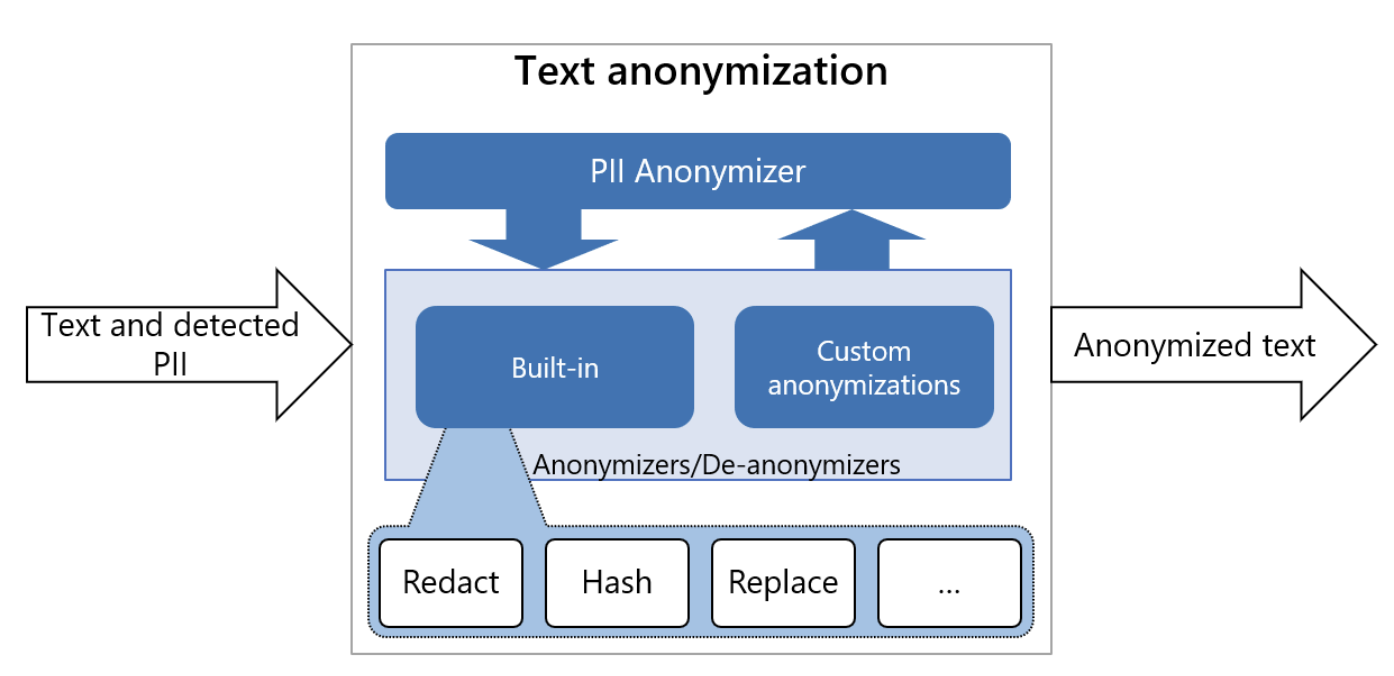

# Anonymizer Example

Replacement

In [ ]:
from presidio_anonymizer import AnonymizerEngine
from presidio_anonymizer.entities import RecognizerResult, OperatorConfig

# Initialize the engine:
engine = AnonymizerEngine()

# Invoke the anonymize function with the text,
# analyzer results (potentially coming from presidio-analyzer) and
# Operators to get the anonymization output:
result = engine.anonymize(
    text="My name is Bond, James Bond",
    analyzer_results=[
        RecognizerResult(entity_type="PERSON", start=11, end=15, score=0.8),
        RecognizerResult(entity_type="PERSON", start=17, end=27, score=0.8),
    ],
    operators={"PERSON": OperatorConfig("replace", {"new_value": "BIP"})},
)

print(result)

text: My name is BIP, BIP
items:
[
    {'start': 16, 'end': 19, 'entity_type': 'PERSON', 'text': 'BIP', 'operator': 'replace'},
    {'start': 11, 'end': 14, 'entity_type': 'PERSON', 'text': 'BIP', 'operator': 'replace'}
]



Encryption

In [ ]:
from presidio_anonymizer import DeanonymizeEngine
from presidio_anonymizer.entities import OperatorResult, OperatorConfig

# Initialize the engine:
engine = DeanonymizeEngine()

# Invoke the deanonymize function with the text, anonymizer results and
# Operators to define the deanonymization type.
result = engine.deanonymize(
    text="My name is S184CMt9Drj7QaKQ21JTrpYzghnboTF9pn/neN8JME0=",
    entities=[
        OperatorResult(start=11, end=55, entity_type="PERSON"),
    ],
    operators={"DEFAULT": OperatorConfig("decrypt", {"key": "WmZq4t7w!z%C&F)J"})},
)

print(result)

text: My name is Chloë
items:
[
    {'start': 11, 'end': 16, 'entity_type': 'PERSON', 'text': 'Chloë', 'operator': 'decrypt'}
]



Use Anonymizer pipeline to produce new text

In [ ]:

# Initialize Presidio components
analyzer = AnalyzerEngine()
anonymizer = AnonymizerEngine()

In [ ]:
def anonymize_text_with_presidio(dataset, operator_config=None):
    """
    Anonymizes each text in the dataset using Presidio with specified operator configurations.

    Parameters:
    - operator_config (dict): A dictionary containing a single key "operators" which maps entity types
                              (e.g., "PERSON", "LOCATION") to their respective OperatorConfig instances.
                              Example: {"operators": {"PERSON": OperatorConfig("replace", {"new_value": "BIP"})}}
    """
    anonymized_texts = []  # List to store anonymized texts for each example
    operators = operator_config.get("operators", {})  # Get the operators from operator_config
    minimal_data = {}      # Dictionary to store minimal data with doc_id as keys

    # Default operator configuration to use if no specific config is found
    default_config = OperatorConfig("replace", {"new_value": "[MASK]"})

    for example in tqdm(dataset, desc="Anonymizing dataset"):
        text = example['text']
        doc_id = example["id"]

        # Analyze the text for PII
        analysis_results = analyzer.analyze(text=text, language='en')

        # Configure anonymizers based on operator_config or fallback to the DEFAULT if provided
        anonymizer_configs = {
            result.entity_type: operators.get(result.entity_type, default_config)
            for result in analysis_results
        }

        # Apply the anonymizer to the text with the configured settings
        anonymized_result = anonymizer.anonymize(
            text=text,
            analyzer_results=analysis_results,
            operators=anonymizer_configs
        )

        # Collect masked spans as [start, end] positions
        masked_spans = [(result.start, result.end) for result in analysis_results]

        # Add the anonymized text to the results list
        anonymized_texts.append({
            "doc_id": doc_id,
            "original_text": text,
            "anonymized_text": anonymized_result.text,
        })

        # Store in minimal data dictionary with doc_id as key
        minimal_data[doc_id] = {
            "doc_id": doc_id,
            "masked_spans": masked_spans
        }



    return anonymized_texts, minimal_data

In [ ]:
from presidio_anonymizer import DeanonymizeEngine
from presidio_anonymizer.entities import OperatorResult, OperatorConfig


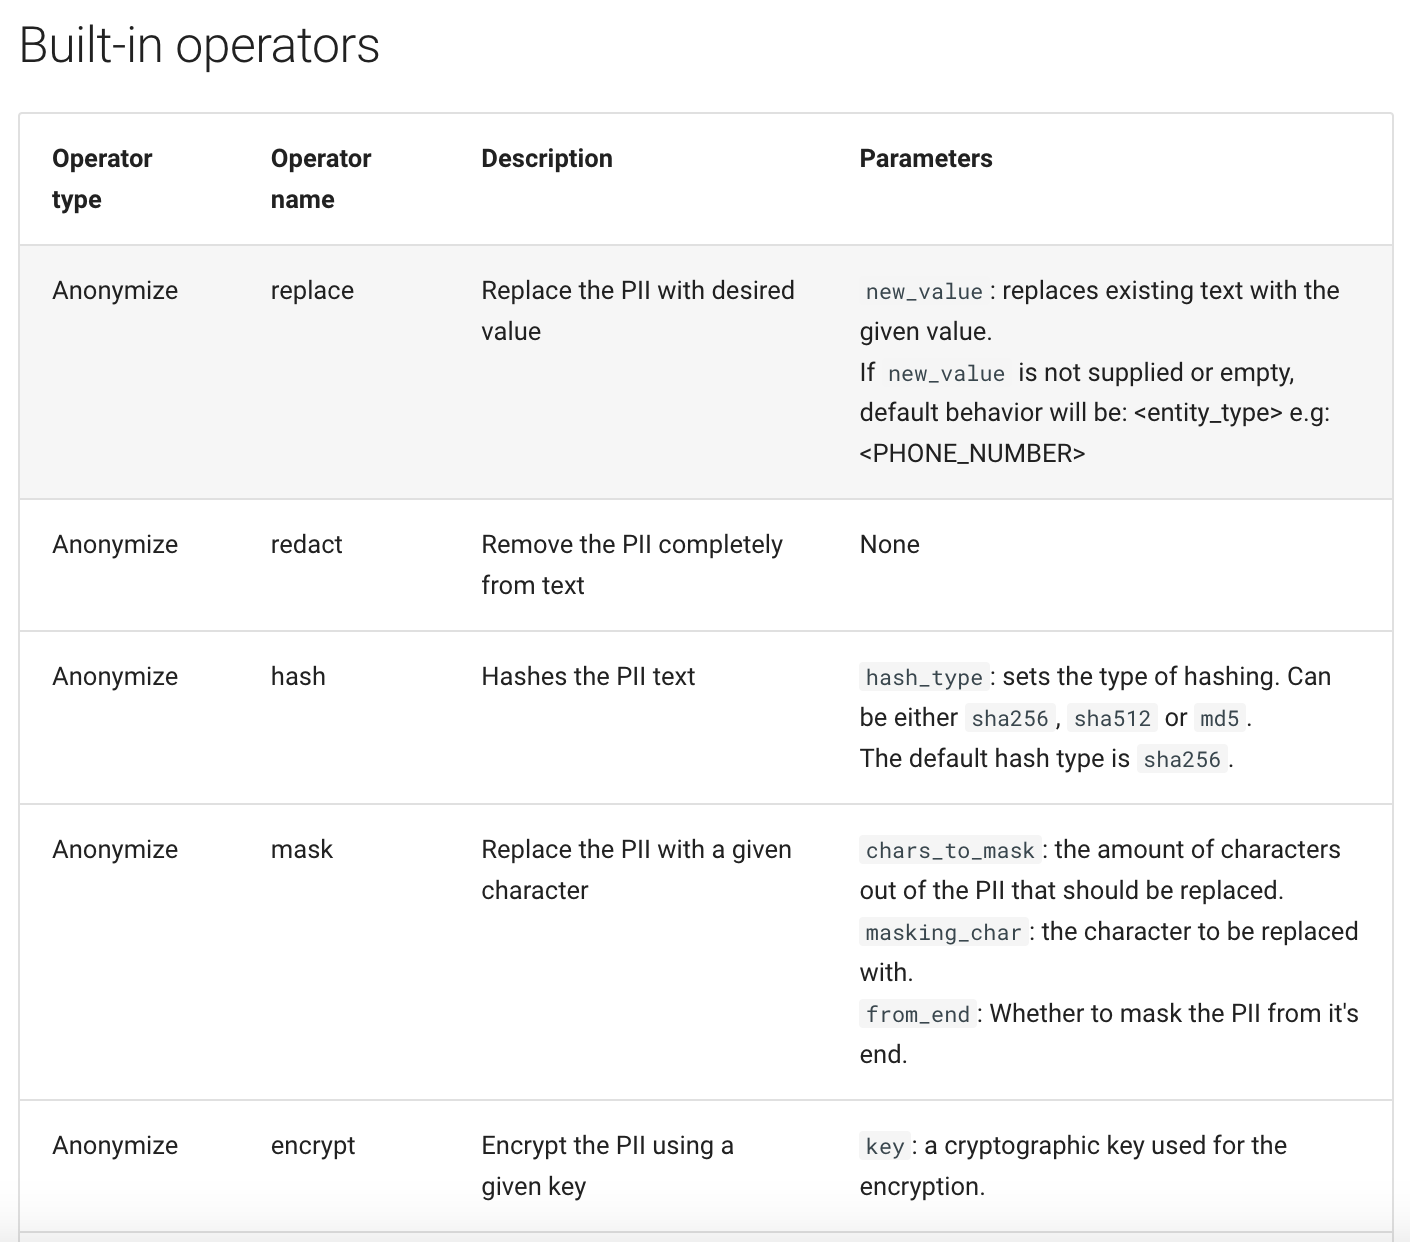

In [ ]:

# Define custom operator configurations for specific entity types and a DEFAULT configuration

# Define operator configurations for specific entity types
operator_config = {
    "operators": {
        "PERSON": OperatorConfig("replace", {"new_value": "BIP"}),
        "LOCATION": OperatorConfig("redact"),  # Example of redaction
        # Add more entity-specific configurations as needed
    }
}
# Anonymize texts using the operator_config only
anonymized_texts, anonymized_texts_minimal = anonymize_text_with_presidio(ds['train'], operator_config=operator_config)



Anonymizing dataset: 100%|██████████| 98/98 [00:43<00:00,  2.25it/s]


In [ ]:

# Save the output to a JSON file
with open(f'{path}data/tab/echr_{model_name}_{split}_{size}_{task}_masked_spans_gold.json', "w") as output_file:
    json.dump(anonymized_texts, output_file, indent=4)

print("Presidio Anonymized texts saved as JSON file.")

# Save the output to a JSON file
with open(f'{path}data/tab/echr_{model_name}_{split}_{size}_{task}_masked_spans.json', "w") as output_file:
    json.dump(anonymized_texts_minimal, output_file, indent=4)

print("Presidio Anonymized texts saved as JSON file.")

Presidio Anonymized texts saved as JSON file.
Presidio Anonymized texts saved as JSON file.
